# Extraction of SWR from CA1 recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from ipyfilechooser import FileChooser

%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer, EventList, InMemoryEventSource
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

In [2]:
dpath = os.path.expanduser("~")
try:
    %store -r dpath
except:
    print("data path not in strore")
    dpath = os.path.expanduser("~")

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>OpenEphys Folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/session5', filename='', title='<b>OpenEphys Fo…

In [3]:
suffix=''
#sep = -5
#animalIDPos = -3
#dirPathComponents = os.path.normpath(dpath).split(os.sep)
#rootPath = os.path.join('/',*dirPathComponents[:sep])
#folder_base = os.path.join(*dirPathComponents[sep:])
#mice = "GreenLinesOK" #dirPathComponents[animalIDPos]
folder_base = dpath
print(folder_base)

/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/session5/


In [4]:
filename = os.path.join(folder_base,f'LFPwake0{suffix}.npy')
filename3 = os.path.join(folder_base,f'LFPwakeremoved{suffix}.npy')
filename2 = os.path.join(folder_base,'RawDataChannelExtractedDS.npy')
EMGbooleaninput = os.path.join(folder_base,f'EMGframeBoolean{suffix}.pkl')
#Channels = os.path.join(folder_base,f'LFPChannels_perMice.xlsx')

EMGboolean = pd.read_pickle(EMGbooleaninput)
LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
All = np.load(filename2, mmap_mode= 'r')
CA1 = All[:, 21]-All[:, 22]
CA1wakeremoved = LFPwakeremoved[:,21]-LFPwakeremoved[:,22]

# Band pass filter
        SWR: 120-200 Hz

In [5]:
# Filtre parameter:
f_lowcut = 120.
f_hicut = 200.
fs = 1000
nyq = 0.5 * fs
N = 6                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_CA1 = signal.filtfilt(b, a, CA1)
filt_CA1wakeremoved = signal.filtfilt(b, a, CA1wakeremoved)

# Plot
times = np.arange(0, CA1.size/fs, 1./fs)
#timesmin = np.arange(0, CA1.size/fs/60, 1./fs/60)
#fig, ax = plt.subplots()
#ax.plot(timesmin, filt_CA1)

## Continuous Wavelet Transform and projection calculation

First on signal with no wake time to determine sd of signal

In [6]:
# Parameter and computation of CWT
w = 10.
freq = np.linspace(120, 200, 80)
widths = w*fs / (2*freq*np.pi)
CA1NWcwt = signal.cwt(filt_CA1wakeremoved, signal.morlet2, widths, w=w)

# Projection calculation
absCA1NWcwt = np.absolute(CA1NWcwt)
proj_CA1NWcwt = np.sum(absCA1NWcwt, axis = 0)/80
sdproj_CA1cwt = np.std(proj_CA1NWcwt)
sd3proj_CA1cwt = sdproj_CA1cwt*3
sd05proj_CA1cwt = sdproj_CA1cwt*0.5

/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/1443763386.py:5: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  CA1NWcwt = signal.cwt(filt_CA1wakeremoved, signal.morlet2, widths, w=w)


Second on the signal for which wake times have been zeroed

In [7]:
# Conservative boolean filtering of CA1 filtered signal
BooleanCons = EMGboolean['BooleanConservative']
fCA1wake0C = filt_CA1.copy()
fCA1wake0C[BooleanCons] = 0
CA1wake0C = CA1.copy()
CA1wake0C[BooleanCons] = 0
# Liberal boolean filtering of CA1 filtered signal
BooleanLib = EMGboolean['BooleanLiberal']
fCA1wake0L = filt_CA1.copy()
fCA1wake0L[BooleanLib] = 0
CA1wake0L = CA1.copy()
CA1wake0L[BooleanLib] = 0

# Computation of CWT
CA1cwtWake0cons = signal.cwt(fCA1wake0C, signal.morlet2, widths, w=w)
CA1cwtWake0lib = signal.cwt(fCA1wake0L, signal.morlet2, widths, w=w)

# Projection calculation
absCA1W0Ccwt = np.absolute(CA1cwtWake0cons)
proj_CA1W0Ccwt = np.sum(absCA1W0Ccwt, axis = 0)/80
absCA1W0Lcwt = np.absolute(CA1cwtWake0lib)
proj_CA1W0Lcwt = np.sum(absCA1W0Lcwt, axis = 0)/80

/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/2403058388.py:15: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  CA1cwtWake0cons = signal.cwt(fCA1wake0C, signal.morlet2, widths, w=w)
/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/2403058388.py:16: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  CA1cwtWake0lib = signal.cwt(fCA1wake0L, signal.morlet2, widths, w=w)


### Display subset 

Not necessary cell to run

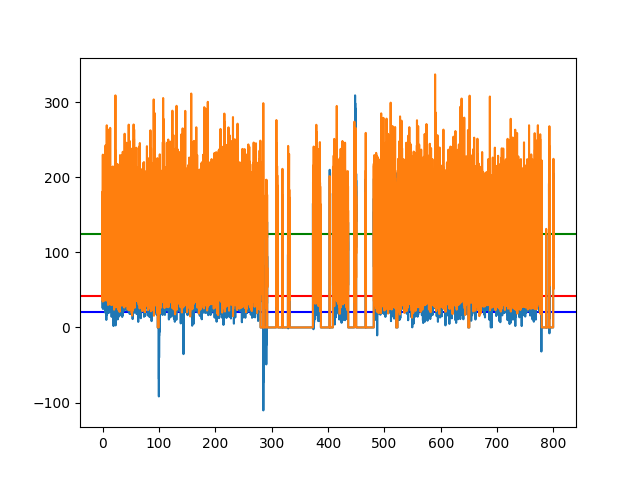

In [8]:
# Defining subset
start = 00000
end = 800000

tt = times[start:end]
CA1t = CA1wake0C[start:end]/10
#CA1cwtt = CA1NWcwt[:, start:end]
proj_CA1cwtt = proj_CA1W0Ccwt[start:end]

plt.close('all')
plt.axhline(sdproj_CA1cwt, color='r') # horizontal
plt.axhline(sd3proj_CA1cwt, color='g') # horizontal
plt.axhline(sd05proj_CA1cwt, color='b') # horizontal
plt.plot(tt, CA1t)
plt.plot(tt, proj_CA1cwtt)
plt.show()

## WARNING: Plot only short subsets (~ 10 s), too memory consuming otherwise
#plt.pcolormesh(tt, freq, np.abs(CA1cwtt), cmap='viridis', shading='gouraud')
#plt.plot(tt, CA1t)
#plt.show()


## Extracting SWRs and determining main properties 

First extraction of SWR peaks, initiation, end and width

In [9]:
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

# 3 sd threshold
peaks, properties = find_peaks(proj_CA1W0Lcwt, prominence=1, width=20, height=sd3proj_CA1cwt)
properties["prominences"], properties["widths"]

# SWR boundaries taken at 70% from peak of intensity. This means that the SWRs with small amplitude will be longer than the big ones.
results_width = peak_widths(proj_CA1W0Lcwt, peaks, rel_height=0.7)

# Organise results in numpy array
peaks2 = peaks.reshape(len(peaks),1)
npresults_width = np.array(results_width).reshape(4,-1)
SWR_prop = np.append(peaks2, results_width).reshape(5,len(peaks2)).round()

Display subset

In [10]:
if False:
    plt.close('all')
    plt.plot(proj_CA1W0Lcwt)
    plt.plot(peakst, proj_CA1W0Lcwt[peaks], "x")
    plt.plot(CA1)
    plt.axhline(sd3proj_CA1cwt, color='r') # horizontal
    plt.vlines(x=peakst, ymin=proj_CA1W0Lcwt[peakst] - propertiest["prominences"], ymax = proj_CA1W0Lcwt[peakst], color = "C1")
    plt.hlines(y=propertiest["width_heights"], xmin=propertiest["left_ips"], xmax=propertiest["right_ips"], color = "C1")
    plt.hlines(*results_widtht[1:], color="C2")
    plt.show()

Second extraction of main frequency and power 

In [11]:
projMaxP_cwtmg = np.max(CA1cwtWake0lib, axis = 0)
projMaxF_cwtmg = np.argmax(CA1cwtWake0lib, axis = 0) + 120
projMaxP_cwtmg.shape

nb_SWR = len(peaks)
data = np.zeros((nb_SWR,4))

for tt in np.arange(nb_SWR):
    SWR_start = int(SWR_prop[3,tt])
    SWR_stop = int(SWR_prop[4,tt])
    SWR_MaxP = projMaxP_cwtmg[SWR_start:SWR_stop]
    SWR_MaxF = projMaxF_cwtmg[SWR_start:SWR_stop]
    data[tt, 0] = max(SWR_MaxF).round()
    data[tt, 1] = max(SWR_MaxP).round()
    data[tt, 2] = round(sum(SWR_MaxF)/len(SWR_MaxF))
    data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))

param_SWR = pd.DataFrame(data, columns = ['Max freq', 'Max int', 'Avg freq', 'Avg int'])
tSWR_prop = SWR_prop.transpose()
pd_prop_SWR = pd.DataFrame(tSWR_prop, columns = ['peak time', 'Duration', 'peak amp', 'start time', 'end time'])
pd_tokeep = pd.DataFrame(np.ones(nb_SWR).astype(bool), columns = ['toKeep'])
All_SWR = pd.concat([pd_tokeep,pd_prop_SWR, param_SWR], axis=1)

SWR_peak = peaks
SWR_start = SWR_prop[3,:].astype(int)
SWR_end = SWR_prop[4,:].astype(int)

/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/2193912474.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 1] = max(SWR_MaxP).round()
/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/2193912474.py:16: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))
/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/2193912474.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  data[tt, 3] = round(sum(SWR_MaxP)/len(SWR_MaxP))


### Store the results in All_SWR_prop pd dataframe and save as pkl/csv for post processing.

End of Notebook. 

In [12]:
filename2 = os.path.join(folder_base,f'SWRproperties{suffix}.pkl')
filename3 = os.path.join(folder_base,f'SWRproperties{suffix}.csv')
All_SWR.to_pickle(filename2)
All_SWR.to_csv(filename3, sep = ',')

combined = np.stack([CA1, filt_CA1, proj_CA1W0Ccwt, proj_CA1W0Lcwt], axis = 1)
filenameC = os.path.join(folder_base,f'SignalCA1.npy')
np.save(filenameC, combined)

# if done and no intention to display for assessment
#%reset
#plt.close('all')

### Display

ephys viewer to check SWR detection

In [13]:
%gui qt

#Create one data source with 3 event channel
all_events = []
conditions = ['All','Good','Bad']
for c,cond in enumerate(conditions):
    match cond:
        case 'All':
            selection = "All_SWR['toKeep'] | ~All_SWR['toKeep']"
        case 'Good':
            selection = "All_SWR['toKeep']"
        case 'Bad':
            selection = "~All_SWR['toKeep']"
    ev_times = All_SWR.loc[pd.eval(selection),'peak time'].values/1000
    ev_labels = [f'SWR {i}'for i in All_SWR[pd.eval(selection)].index]
    all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
source_ev = InMemoryEventSource(all_events=all_events)

app = mkQApp()

sample_rate = 1000.
t_start = 0.

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: SWR_peak, 1: SWR_start, 2: SWR_end}
#and asign them to some channels each
scatter_channels = {0: [1, 2], 1: [0, 1], 2: [0, 1]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#ff5500'
view1.by_channel_params['ch3', 'color'] = '#ffffff'

view1.by_channel_params['ch0', 'gain'] = 0.001
view1.by_channel_params['ch1', 'gain'] = 0.005
view1.by_channel_params['ch2', 'gain'] = 0.005
view1.by_channel_params['ch3', 'gain'] = 0.005


view1.by_channel_params['ch0', 'offset'] = 6
view1.by_channel_params['ch1', 'offset'] = -1
view1.by_channel_params['ch2', 'offset'] = -1
view1.by_channel_params['ch3', 'offset'] = -1


view2 = EventList(source=source_ev, name='event')


#put this viewer in the main window
win.add_view(view1)
win.add_view(view2, location='bottom',  orientation='horizontal')

#Run
win.show()
app.exec_()

debug True
QT_MODE PySide6
refresh duration for  7.605552673339844e-05 s
refresh duration for  9.083747863769531e-05 s
refresh duration for event 2.1457672119140625e-06 s


/var/folders/2_/fpwjwx512255f113wntjtndm0000gn/T/ipykernel_86476/4264298192.py:67: DeprecationWarning: 'exec_' will be removed in the future. Use 'exec' instead.
  app.exec_()


refresh duration for  0.00016188621520996094 s
refresh duration for  0.0003173351287841797 s
refresh duration for  0.00011897087097167969 s
refresh duration for  0.0003521442413330078 s


qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=704.887,309.715 gbl=704.887,309.715 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-704.887,-309.715 last=-704.887,-309.715 Δ 704.887,309.715) : no target window


save_all_settings


0

Quick plot of average and max intensity (can be done with freq as well) paired.

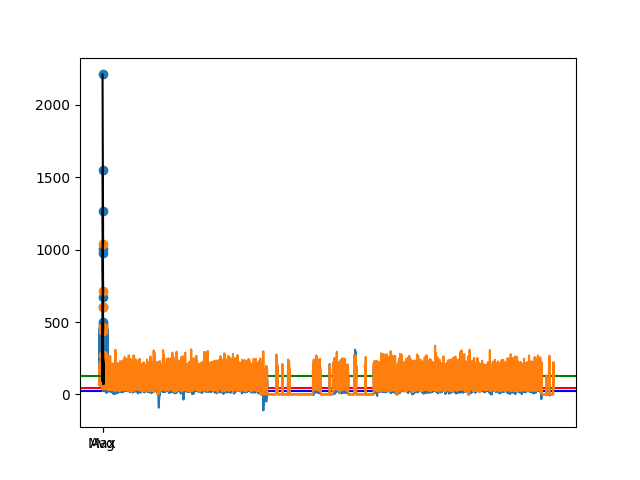

In [14]:

# input data:
MaxSWR = param_SWR['Max int']
AvgSWR = param_SWR['Avg int']

# plotting the points
plt.scatter(np.zeros(len(MaxSWR)), MaxSWR)
plt.scatter(np.ones(len(AvgSWR)), AvgSWR)

# plotting the lines
for i in range(len(MaxSWR)):
    plt.plot( [0,1], [MaxSWR[i], AvgSWR[i]], c='k')

plt.xticks([0,1], ['Max', 'Avg'])
plt.show()